In [1]:
#%run utility_getinputhits.py

In [1]:
from pylab import *
import pandas as pd
from timeit import default_timer as timer
DatasetFile   = 'CMSSW9304_partGun_PDGid22_x100_E30.0To30.0_NTUP'
df = pd.read_pickle("../../data/input/"+DatasetFile+"_rechit.pkl")

In [2]:
KERNAL_R,KERNAL_Z= 2,2 #cm
MAXDISTANCE = 200 #cm
DECISION_RHO_KAPPA = 10
DECISION_NHD = 5 #cm
AFFINITY_Z = 0.5
CONTINUITY_NHD = 4 #cm

# 0.Load Events

In [3]:
dfevt = df.query("id<10")
dfevt = dfevt.reset_index(drop=True)
x,y,z,energy = np.array(dfevt.x),np.array(dfevt.y),AFFINITY_Z*np.array(dfevt.z),np.array(dfevt.energy)

# 1. Find rho and NearestHigher

In [4]:
start = timer()
nrech = energy.size
# find rho and rhorank
rho = []
for i in range(nrech):
    dr = ((x-x[i])**2 + (y-y[i])**2)**0.5
    dz = np.abs(z-z[i])
    local = (dr<KERNAL_R) & (dz<KERNAL_Z)
    irho = np.sum(energy[local] *np.exp(-dr[local]/1.0) *np.exp(-dz[local]/4.0))
    rho.append(irho)
rho = np.array(rho)
argsortrho = rho.argsort()[::-1]
rhorank = np.empty(len(rho), int)
rhorank[argsortrho] = np.arange(len(rho))

# find NearstHiger and distance to NearestHigher
nh,nhd = [],[]
for i in range(nrech):
    irho = rho[i]
    irank= rhorank[i]
    if irank==0:
        nh. append(i)
        nhd.append(MAXDISTANCE)
    else:
        higher = rho>irho
        drr  = ((x[higher]-x[i])**2 + (y[higher]-y[i])**2 + (z[higher]-z[i])**2)**0.5
        temp = np.arange(len(rho))[higher]
        nh. append(temp[np.argmin(drr)])
        nhd.append(np.min(drr))
nh = np.array(nh)
nhd= np.array(nhd)

end = timer()
print("number of rechits: {}".format(nrech))
print("time: {:3.6} ms".format(1000*(end - start)))

number of rechits: 10173
time: 3102.2 ms


# 2. Asign Clusters

In [5]:
cluster = -np.ones(nrech,int)
DECISION_RHO = rho.max()/DECISION_RHO_KAPPA

# 2.2 find seeds
selectseed = (rho>DECISION_RHO) & (nhd>DECISION_NHD)
seedrho = rho[selectseed]
temp = seedrho.argsort()[::-1]
seedid = np.empty(len(seedrho), int)
seedid[temp] = np.arange(len(seedrho))
cluster[selectseed] = seedid
dfevt['isseed'] = pd.Series(selectseed.astype(int), index=dfevt.index)

# 2.3 asign clusters to seeds
for ith in range(nrech):
    i = argsortrho[ith]
    if  (cluster[i]<0) & (nhd[i]<CONTINUITY_NHD):
        cluster[i] = cluster[nh[i]]

In [6]:
dfevt['rho'] = pd.Series(rho, index=dfevt.index)
dfevt['rhorank'] = pd.Series(rhorank, index=dfevt.index)
dfevt['nh'] = pd.Series(nh, index=dfevt.index)
dfevt['nhd'] = pd.Series(nhd, index=dfevt.index)
dfevt['cluster'] = pd.Series(cluster, index=dfevt.index)
#dfevt.to_pickle("../data/test.pkl")
#dfevt.to_csv("../data/test.csv")

# Make Plots

In [7]:
%matplotlib inline
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

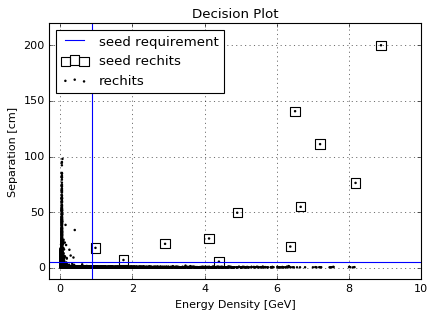

In [10]:
plt.scatter(dfevt.rho[selectseed],dfevt.nhd[selectseed],marker='s',
            s=70,edgecolor="k",color="None",label="seed rechits")
plt.scatter(dfevt.rho,dfevt.nhd,marker='.',edgecolor="None",color="k",label="rechits")
plt.axvline(DECISION_RHO,color="b",label="seed requirement")
plt.axhline(DECISION_NHD,color="b")

plt.xlabel("Energy Density [GeV]")
plt.ylabel("Separation [cm]")
plt.legend(loc="upper left",fontsize=12)
plt.xlim(-0.3)
plt.ylim(-10,220)
plt.grid(True)
plt.title("Decision Plot",fontsize=12)

plt.savefig("../../plot/decision_cpu.png")

In [9]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
init_notebook_mode(connected=True)

dfevt = dfevt.reset_index(drop=True)
rechits = go.Scatter3d(x=dfevt.ox,y=dfevt.oz,z=dfevt.oy,
                       mode='markers',
                       marker=dict(size=5*dfevt.energy**0.3,color=dfevt.cluster,colorscale='Jet',cmax=10,cmin=-2,opacity=0.5,
                                   line = dict(width = 0))) 
data = [rechits]
layout = go.Layout(scene=dict(xaxis=dict(title='x (cm)'), yaxis=dict(title='z (cm)'), zaxis=dict(title='y (cm)')),
                   margin=dict(l=0,r=0,b=0,t=0))

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='Ten 30GeV Photon ImageAlgo3D_cpu')

In [20]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
init_notebook_mode(connected=True)

dfevt = dfevt.reset_index(drop=True)
mysize= 2+2*(1-np.exp(-dfevt.rho))
rechits = go.Scatter3d(x=dfevt.ox,y=dfevt.oz,z=dfevt.oy,
                       mode='markers',
                       marker=dict(size=mysize,color=dfevt.cluster,colorscale='Jet',cmax=2.2,cmin=-1.5,opacity=1,
                                   line = dict(width = 0))) 
data = [rechits,genpart]
layout = go.Layout(scene=dict(xaxis=dict(title='x (cm)'), yaxis=dict(title='z (cm)'), zaxis=dict(title='y (cm)')),
                   margin=dict(l=0,r=0,b=0,t=0))

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='Ten 300GeV Photon ImageAlgo3D_cuda') #2+1*dfevt.energy**0.5

NameError: name 'genpart' is not defined

In [13]:
from root_pandas import read_root
from utility_eventdisplay import *
ntuple = read_root("../data/"+DatasetFile+".root",'ana/hgc')

Welcome to JupyROOT 6.10/00


In [14]:
gen = np.zeros([1,3])
for i in range(3,4):
    geni = LoadEvent(i,ntuple)[0]
    geni = geni[geni.z>0]
    geni = array(geni[["x","y","z"]])
    gen = np.append(gen,geni, axis=0)
genx = gen[:,0]
geny = gen[:,1]
genz = gen[:,2]
genx = np.insert(genx,np.arange(genx.size),0,0)
geny = np.insert(geny,np.arange(geny.size),0,0)
genz = np.insert(genz,np.arange(genz.size),0,0)

genpart = go.Scatter3d(x=genx,y=genz,z=geny,mode='lines',
                       marker=dict(size=0,color="gray",opacity=1),
                       line = dict(width = 2,color="gray")) 

In [33]:
layer = np.zeros([1,4])
for i in range(1):
    layerx = ntuple.cluster2d_x[i]
    layery = ntuple.cluster2d_y[i]
    layerz = ntuple.cluster2d_z[i]
    layere = ntuple.cluster2d_energy[i]
    layeri = np.c_[layerx,layery,layerz,layere]
    layer  = np.append(layer,layeri,axis=0)

layer = layer[(layer[:,3]>0) & (layer[:,2]>0)]
mysize = 10*(1.2-np.exp(-1*layer[:,3]))
layerclusterCMSSW = go.Scatter3d(x=layer[:,0],
                                 y=layer[:,2],
                                 z=layer[:,1],
                                 mode='markers',
                                 marker=dict(size=mysize,color=mysize,colorscale='Jet',opacity=0.5))

In [34]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
init_notebook_mode(connected=True)

dfevt = dfevt.reset_index(drop=True)
rechits = go.Scatter3d(x=dfevt.ox,y=dfevt.oz,z=dfevt.oy,
                       mode='markers',
                       marker=dict(size=5*(1-np.exp(-1*dfevt.energy)),color=dfevt.cluster,colorscale='Jet',cmax=dfevt.cluster.max(),cmin=-2,opacity=0.5,
                                   line = dict(width = 0))) 

data = [layerclusterCMSSW,genpart]
layout = go.Layout(scene=dict(xaxis=dict(title='x (cm)'), yaxis=dict(title='z (cm)'), zaxis=dict(title='y (cm)')),
                   margin=dict(l=0,r=0,b=0,t=0))

fig = go.Figure(data=data, layout=layout)
plot(fig, filename='Ten 300GeV Photon ImageAlgo3D CMSSW')

/Users/zihengchen/anaconda/lib/python3.6/site-packages/plotly/offline/offline.py:459: UserWarning:

Your filename `Ten 300GeV Photon ImageAlgo3D CMSSW` didn't end with .html. Adding .html to the end of your file.



'file:///Users/zihengchen/Documents/HGCal/clustering/debug/Ten 300GeV Photon ImageAlgo3D CMSSW.html'